## Домашнее задание 3 "Бинарный классификатор на основе CNN"

ФИО: Фадеев Роман Андреевич

### Импорт основных библиотек

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter

### Распаковка архива "indoor_outdoor_dataset.zip" с датасетом

In [2]:
import zipfile

zip_file = 'indoor_outdoor_dataset.zip'
output_dir = './big-data'
try:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
except:
    print("Cant find zip file, skipping")


Cant find zip file, skipping


### Подготовка тренировочной, валидационной и тестовой выборок

In [3]:
TRAIN_FROM_CHECKPOINT = False

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=output_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

Данные разделяю по 256 батчей (~ 3.5 GB VRAM) для более быстрой обработки

In [4]:
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
batch_size = 128 # Уменьшить при переполнении памяти

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Посмотрим распределение данных датасета

In [5]:
# class_counter = Counter()

# for inputs, labels in train_loader:
#     class_counter.update(labels.cpu().numpy())

# print("Class distribution:", class_counter)

# plt.bar(class_counter.keys(), class_counter.values())
# plt.xlabel('Class Labels')
# plt.ylabel('Frequency')
# plt.title('Class Distribution')
# plt.show()

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # rgb
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Инициализация кастомного датасета.
        
        :param images: Список изображений (тензоров или numpy массивов).
        :param labels: Список меток (тензоров или numpy массивов).
        :param transform: (необязательный) трансформации, которые нужно применить к изображениям.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Возвращает общее количество элементов в датасете."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Возвращает элемент по индексу.
        
        :param idx: Индекс элемента.
        :return: Кортеж (изображение, метка).
        """
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
model = CNNModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""

    torch.save(state, filename)

def load_checkpoint(filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

In [10]:
indices = np.random.choice(
    len(train_loader.dataset),
    int(0.1 * len(train_loader.dataset)),
    replace=False   
)

train_subset = Subset(train_loader.dataset, indices)
train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)

In [11]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

class OutInModel:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.writer = SummaryWriter('runs/exp_1')

        self.augmentation_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

        self.incorrect_images = []
        self.incorrect_labels = []

    def create_plot(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_epochs, label='Train')
        plt.plot(self.val_loss_epochs, label='Val')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracy_epochs, label='Train accuracy')
        plt.plot(self.val_accuracy_epochs, label='Val accuracy')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracy', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
    def train_model(self, train_loader, val_loader, num_epochs=10, rec=False, plot=True):
        try:
            self.train_loss_epochs = []
            self.val_loss_epochs = []
            self.train_accuracy_epochs = []
            self.val_accuracy_epochs = []

            best_val_acc = 0.0
            
            for epoch in tqdm(range(num_epochs)):
                self.model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                self.incorrect_images = []
                self.incorrect_labels = []
                
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

                    self.optimizer.zero_grad()
                    
                    outputs = model(inputs)
                    loss = self.criterion(outputs, labels)
                    
                    loss.backward()
                    self.optimizer.step()
                    
                    running_loss += loss.item()
                    predicted = (outputs > 0.5).float()
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                
                    if epoch + 1 == num_epochs:
                        incorrect_idx = (predicted != labels).squeeze()
                        self.incorrect_images += inputs[incorrect_idx].cpu()
                        self.incorrect_labels += labels[incorrect_idx].cpu() 
                
                train_loss = running_loss / len(train_loader)
                train_acc = correct / total
                
                val_loss, val_acc = self.evaluate_model(val_loader)

                self.train_loss_epochs.append(train_loss)
                self.train_accuracy_epochs.append(train_acc)

                self.val_loss_epochs.append(val_loss)
                self.val_accuracy_epochs.append(val_acc)
                
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
                    f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
                
                if plot:
                    self.create_plot()
                
                self.writer.add_scalar('Loss/train', train_loss, epoch)
                self.writer.add_scalar('Accuracy/train', train_acc, epoch)
                self.writer.add_scalar('Loss/val', val_loss, epoch)
                self.writer.add_scalar('Accuracy/val', val_acc, epoch)
                
                if val_acc > best_val_acc:
                    print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
                    best_val_acc = val_acc
                    
                    checkpoint = {
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': val_loss,
                        'accuracy': val_acc
                    }
                    save_checkpoint(checkpoint, 'cnn_best_checkpoint.pth')
            
            if rec:
                incorrect_images_tensor = torch.stack(self.incorrect_images)  # Преобразуем список изображений в тензор
                incorrect_labels_tensor = torch.stack(self.incorrect_labels)  # Преобразуем список меток в тензор
                
                dl = DataLoader(
                    dataset=CustomTensorDataset(
                        tensors=(incorrect_images_tensor, incorrect_labels_tensor),  # Передаем кортеж тензоров
                        transform=self.augmentation_transforms  # Передаем трансформацию
                    ),
                    batch_size=batch_size,
                    shuffle=True,
                )
                self.train_model(dl, 
                                 val_loader, 
                                 num_epochs=num_epochs, 
                                 rec=False, 
                                 plot=True
                                 )

        except KeyboardInterrupt:
            print("Interrupted")

            pass

    def evaluate_model(self, loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

                outputs = model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        loss = running_loss / len(loader)
        accuracy = correct / total

        return loss, accuracy

In [12]:
ou_model = OutInModel(model, criterion, optimizer)

  0%|                                                                                              | 0/4 [00:00<?, ?it/s]

Epoch [1/4], Loss: 0.3144, Accuracy: 0.8717, Val Loss: 0.2609, Val Accuracy: 0.8984


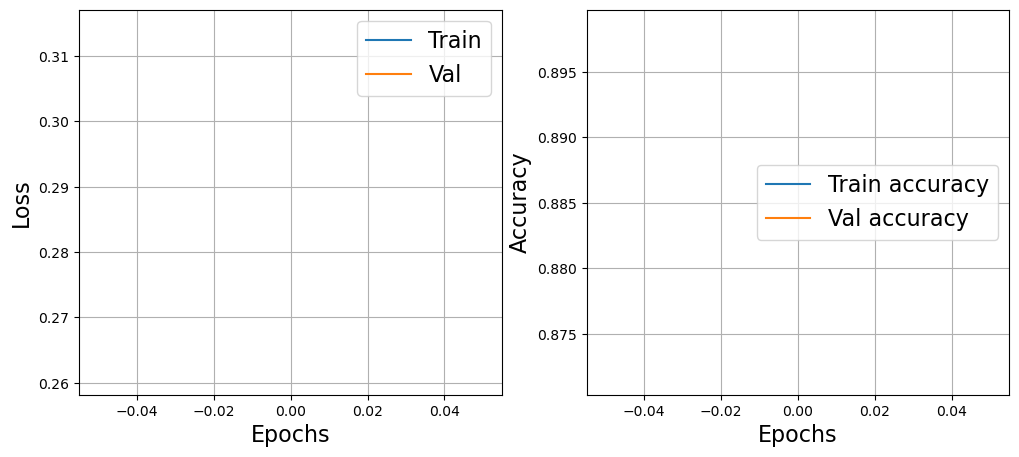

Validation accuracy improved from 0.0000 to 0.8984. Saving model...


 25%|█████████████████████                                                               | 1/4 [18:50<56:32, 1130.87s/it]

Epoch [2/4], Loss: 0.2453, Accuracy: 0.9014, Val Loss: 0.2349, Val Accuracy: 0.9003


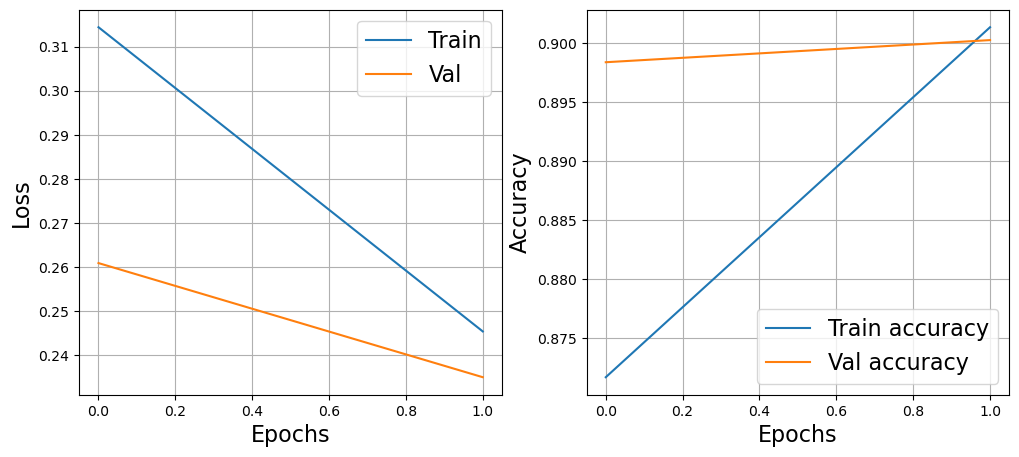

 50%|██████████████████████████████████████████                                          | 2/4 [37:42<37:42, 1131.07s/it]

Validation accuracy improved from 0.8984 to 0.9003. Saving model...
Epoch [3/4], Loss: 0.2161, Accuracy: 0.9134, Val Loss: 0.2223, Val Accuracy: 0.9101


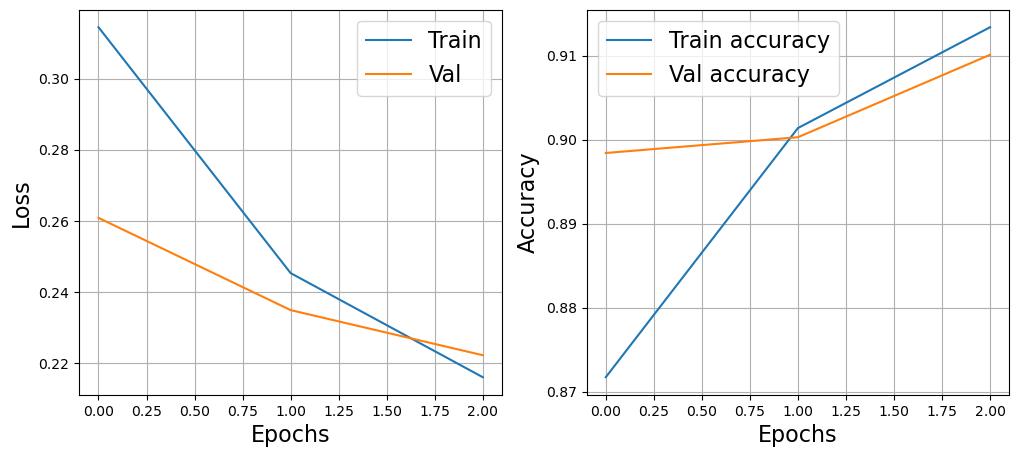

Validation accuracy improved from 0.9003 to 0.9101. Saving model...


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [57:52<19:27, 1167.23s/it]

Epoch [4/4], Loss: 0.1967, Accuracy: 0.9215, Val Loss: 0.2159, Val Accuracy: 0.9222


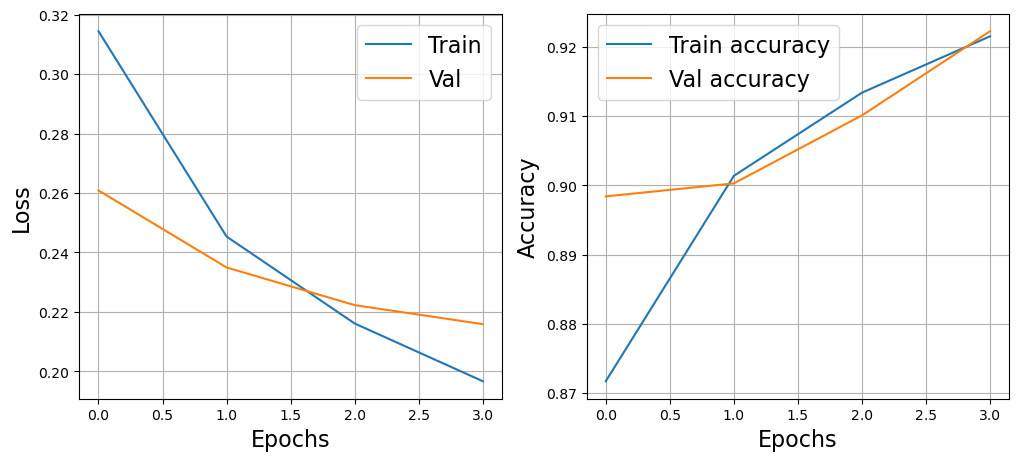

Validation accuracy improved from 0.9101 to 0.9222. Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [1:20:21<00:00, 1205.38s/it]


In [13]:
if not TRAIN_FROM_CHECKPOINT:
    torch.cuda.empty_cache()
    ou_model.train_model(train_loader, val_loader, num_epochs=4)

Error Class distribution:


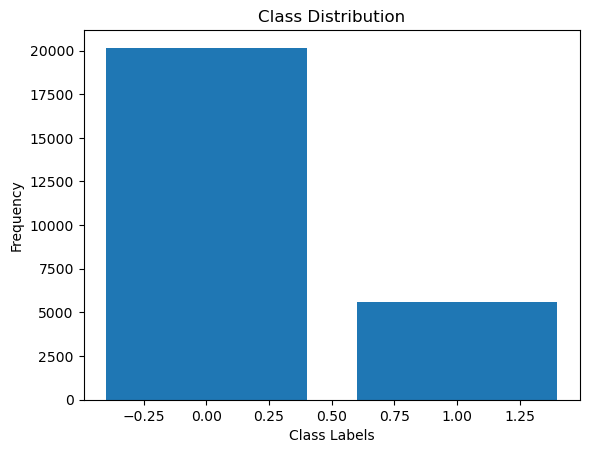

In [14]:
print("Error Class distribution:")
class_counter = Counter([label.item() for label in ou_model.incorrect_labels])
plt.bar([0,1], class_counter.values())
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [15]:
if TRAIN_FROM_CHECKPOINT:    
    model = CNNModel().to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint.pth')

    train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=10,
    )

### Загрузка лучшего чекпоинта

In [16]:
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint.pth')

model.eval()

Checkpoint loaded. Epoch: 4, Loss: 0.21588405727690255, Accuracy: 0.9222449576147326


CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

### Определение ошибочно предсказанных изображений, метрик.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


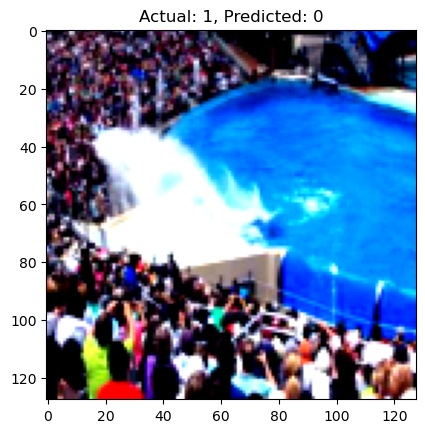

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


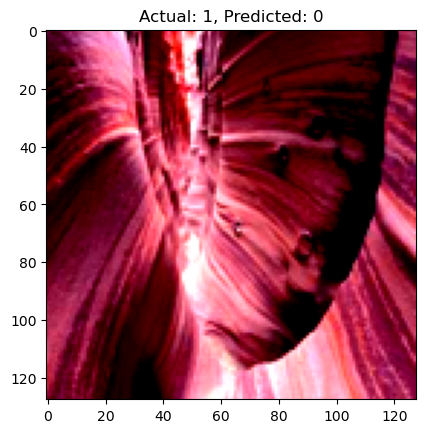

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


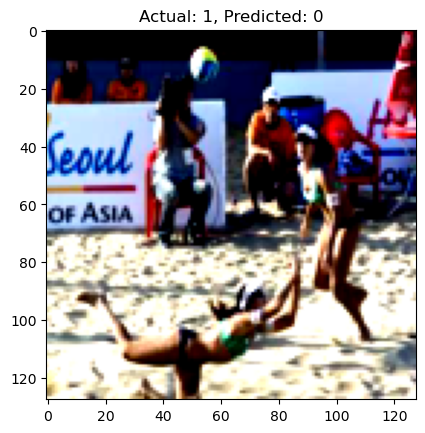

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


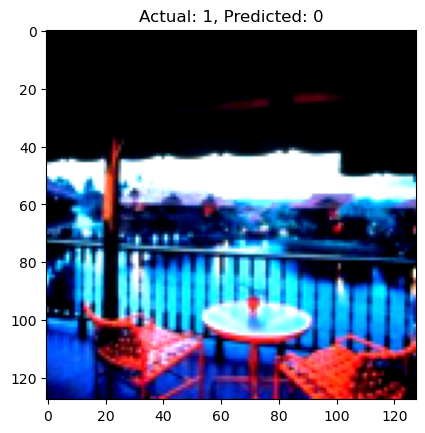

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


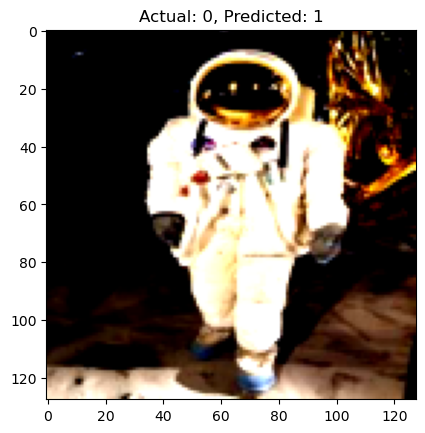

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


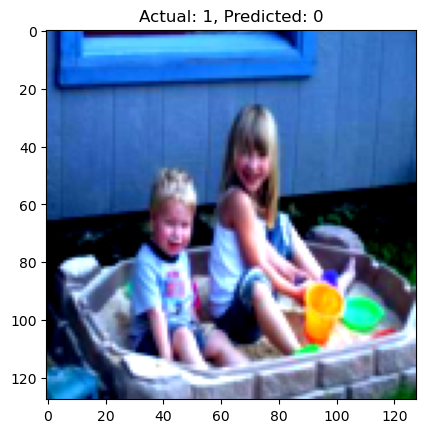

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


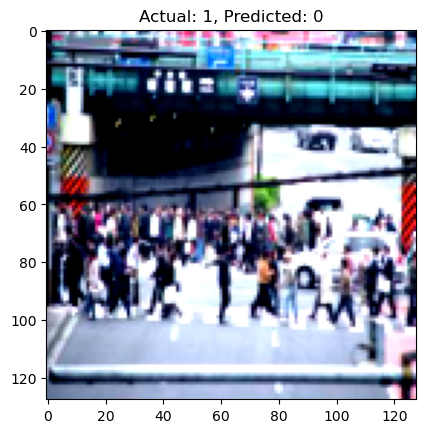

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


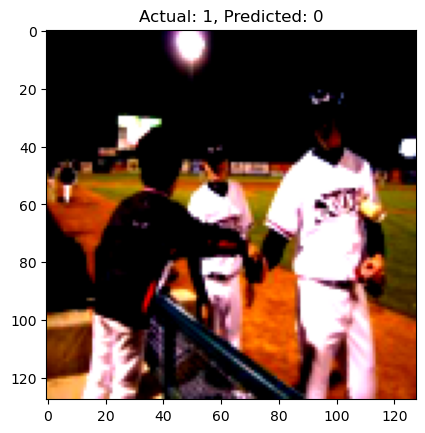

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


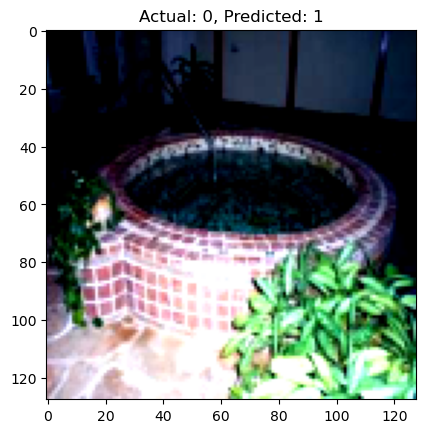

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


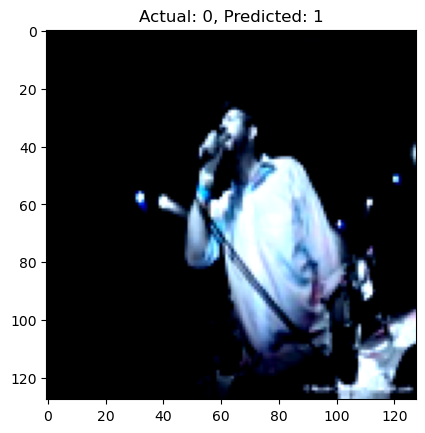

In [17]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns

def imshow(img, title):
    """Функция для отображения изображения"""
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def inference_and_visualize_errors(model, test_loader):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float().view(-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(predicted[idx].cpu().item())

    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    for i in range(min(10, len(incorrect_images))):
        imshow(incorrect_images[i], f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

        ou_model.writer.add_image(f'Error_{i}', incorrect_images[i])
        ou_model.writer.add_text(f'Error_{i}', f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

    return f1, conf_matrix, acc

f1, conf_matrix, acc = inference_and_visualize_errors(model, test_loader)

### Результаты модели

F1-score: 0.9179
Accuracy: 0.9235


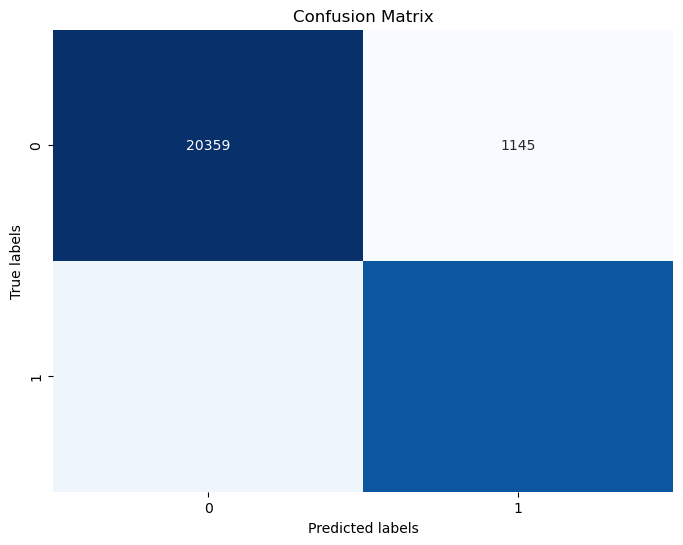

In [18]:
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {acc:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Количество обучаемых параметров

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {count_parameters(model)}")

Количество обучаемых параметров: 8779009


In [21]:
ou_model.writer.close()

%load_ext tensorboard

# Путь к логам
log_dir = 'runs/exp_1'

# Запуск TensorBoard
%tensorboard --logdir=runs/exp_1

from IPython.display import IFrame

IFrame(src='http://localhost:6006/', width=1000, height=800)

### Выводы

- В данной домашней работе сильно помогло использование батчей, встроенных в pyTorch. Т.к. датасет очень большой, обучение шло очень долго, однако при полной загрузке VRAM удалось достичь результата в ~20 мин/эпоха;
- Для модели используется достаточно классическая реализация, поэтому сложно сказать, что помогло повысить accuracy. Скорее всего, здесь прямая зависимость между тренировочной выборкой и результатами модели;
- При выполнении работы также было полезно использовать чекпоинты для модели, чтобы обучение не происходило сначала;
- Модель перестала обучаться на пятой эпохе, а стала больше подстраиваться под тренировочный датасет;
- Результат можно улучшить, используя аугментацию, однако очень сложно манипулировать с таким большим объемом данных.
- В итоге Accuracy - 0.9129 за 5 эпох (~2 часа обучения).